# Sparkify Project


##  Project Overview

This workspace contains a medium sized (240MB) of the full dataset available (12GB). 
This notebook to analyze a subset of the big data (12GB) before deploying a spark cluster on the cloud using aws cloud to analyze larger amount of data.

### What is Sparkify

It is a fake popular digital music service similar to Spotify or Panadora, millions of users stream their favorite songs to this service every day either using the free tier that place advertisments between the songs, or using premium subscription model where they stream music as free  but pay a monthly flat rate, users can upgrade, downgrade, or cancel their service at any time, so it's crusial to make sure the users love the sevice.

## Problem Statement
The data contains the key insights for keeping users happy and helping the business thrive, so me as a data scientist, my rule is helping the business growing and growing, so I can predict which users at risk to churn either downgrading from premium to free tier or cancelling their service alltogether, predicting these users before they leave accurately the business can offer them discounts and incentives, potentially saving this business millions in revenue. 

### Project steps

* Load data into Spark
* Explore and clean data
* create Features
* Build models and compare between them 
* predict the churn according to the best model

## Evaluation Metrics

My main purpose of this project is to predict if the user will churn or not, the best metric to evaluate my prediction is by using F1 score, that Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial, and in this prediction the False Negatives and False Positives are crucial, so using f1 score will be more helpful, also Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes. in my case I have imbalanced class that the churned users are much more than the stayed users (as in the define churn part), In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on.


In [2]:
# import libraries
from pyspark.context import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F 
from pyspark.sql.functions import to_date, datediff
from pyspark.sql.functions import concat, lit, avg, split, isnan, when, count, col, sum, mean, stddev, desc, asc
from pyspark.sql import Window

from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF, StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler

from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

In [3]:
#import libraries for data manipulation and plotting
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Clean Dataset

### Load Data and Take a Look at It

In [7]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-bed0b6a9-7740-45ff-876e-ac1e1cc230ec',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'ZmqwAQhxJ5oP0GU7Ao0h9mfTGfBOgpYsuwTP36fA368Z'
}

configuration_name = 'os_e83c2441f75e4c1d8fe717fd4d76b613_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

logs = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-8omoghv3ewyuly'))
logs.take(5)


DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [8]:
logs.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
logs.describe("length").show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            432877|
|   mean|248.66459278007807|
| stddev| 98.41266955052018|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



In [10]:
logs.show(n=1)

+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+---------

In [11]:
logs.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [12]:
#number of rows 
logs.count()

543705

In [13]:
def show_unique_cat(df):
    '''
    showing the unique values for categorical values
    page-level-method-status
    
    INPUT -> df_data spark dataframe
    OUTPUT -> showing the unique values
    '''
    
    #see the page types in the dataset
    df.select('page').dropDuplicates().sort('page').show()

    #see the level types
    df.select('level').dropDuplicates().sort('level').show()

    #see the method values
    df.select('method').dropDuplicates().show()

    #see the status values
    df.select('status').dropDuplicates().show()

show_unique_cat(logs)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



### Missing Values

#### Explore Missing Values

In [14]:
#percent of missing values in every column
columns = logs.describe().columns[1:]
missing_values = {}
for column in columns:
    missing_values[column] = round(logs.select(['userId']).where(logs[column].isNull()).count() / logs.count()*100, 2)
    

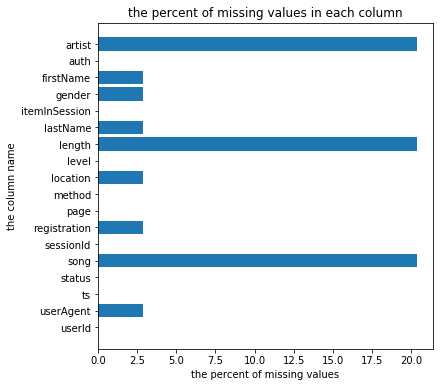

In [15]:
#plot the percent 

fig, ax = plt.subplots(figsize=(6,6))

# Example data
y_pos = np.arange(len(missing_values))

ax.barh(y_pos, list(missing_values.values()), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(missing_values.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('the percent of missing values')
ax.set_ylabel('the column name')
ax.set_title('the percent of missing values in each column')

plt.show()


In [16]:
#see the rows thar has missing values
logs.select(['userId','page', 'userAgent', 'registration', 'location', \
           'firstName', 'lastName', 'gender', 'song', 'length', 'artist','status']) \
.where(logs['firstName'].isNull()).show(n=100)

+------+-----+---------+------------+--------+---------+--------+------+----+------+------+------+
|userId| page|userAgent|registration|location|firstName|lastName|gender|song|length|artist|status|
+------+-----+---------+------------+--------+---------+--------+------+----+------+------+------+
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|   307|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | Help|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | H

In [17]:
logs.select(['userId','page', 'userAgent', 'registration', 'location', \
           'firstName', 'lastName', 'gender', 'song', 'length', 'artist', 'status']) \
.where(logs['userId']=='').show(n=100)

+------+-----+---------+------------+--------+---------+--------+------+----+------+------+------+
|userId| page|userAgent|registration|location|firstName|lastName|gender|song|length|artist|status|
+------+-----+---------+------------+--------+---------+--------+------+----+------+------+------+
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|   307|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | Help|     null|        null|    null|     null|    null|  null|null|  null|  null|   200|
|      | H

From the above, we notice that the same rows have the null values in the different columns in the dataset, and at the same time the userId column is empty

In [18]:
#show the percent of the empty user ids in the dataset
round(logs.select(['page']).where(logs['userId']=='').count()/logs.count()*100,2) 

2.89

so the percent of empty userId is the same as the percent of the missing values in many of the columns, so the rows with empty userId is the same as the rows with missing valuesin many of columns, this makes a sence, I'll take a look at the page types.

In [19]:
#show the pages that have got empty user id
logs.select(['page']).where(logs['userId']=='').dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [20]:
#show the pages that haven't got empty user id
logs.select(['page']).where(logs['userId']!='').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



The pages that have got empty userId and have not got userId values are `Register`, `login`, `Submit Registeration`, this means when the customer doesn't login, so he has not userId and then no data. Now I will take a look at the columns with 20% missing values to be able to recognize the situation.

In [21]:
#Take a look at the userIds and the page types when the artist is not null
logs.select(['page']).where(logs['artist'].isNotNull()).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [22]:
#Take a look at the userIds and the page types when the song is not null
logs.select(['page']).where(logs['song'].isNotNull()).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



So the artist,song, and length columns have got values when the page type is NextPage

#### Clean missing values
        

In [23]:
def clean(df, print_count=True):
    '''
    perform data cleaning on sparkify dataset
    
    INPUT -> pyspark dataframe containing sparkify logs events
    
    OUTPUT -> pyspark dataframe with no missing values or empty userId
    '''
    #remove the data that have not userId
    df = df.filter(df['userId'] != "")

    #remove missing values
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])

    # remove null values at artist, song and length features by selecting the NextSong Page
    #df = df.filter(df.artist.isNotNull())

    if print_count:
        print('the number of missig values in every column in the dataset:\n')
        #Test
        for col in columns:
            print(col, df.select(['userId']).where(df[col].isNull()).count())
        
    return df

In [24]:
logs_new = clean(logs)

the number of missig values in every column in the dataset:

artist 95128
auth 0
firstName 0
gender 0
itemInSession 0
lastName 0
length 95128
level 0
location 0
method 0
page 0
registration 0
sessionId 0
song 95128
status 0
ts 0
userAgent 0
userId 0


In [25]:
logs_new.groupby('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    99|
|    Submit Downgrade|   117|
|         Thumbs Down|  4911|
|                Home| 19089|
|           Downgrade|  3811|
|         Roll Advert|  7773|
|              Logout|  5990|
|       Save Settings|   585|
|Cancellation Conf...|    99|
|               About|  1026|
|            Settings|  2964|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|            NextSong|432877|
|           Thumbs Up| 23826|
|                Help|  2644|
|             Upgrade|   968|
|               Error|   503|
|      Submit Upgrade|   287|
+--------------------+------+



## Exploratory Data Analysis

Performing EDA by loading a small subset of the data and doing basic manipulations within Spark 
This EDA will pbe performed on the uncleaned dataset to see the behavour of all users



### preliminary analysis
Doing some basic analysis to build intuition about the data

In [26]:
#number of unique users in the cleaned dataset
logs_new.select('userId').dropDuplicates().count()

448

In [27]:
#number of unique artist
logs_new.select('artist').dropDuplicates().count()


21248

#### Explore Location Feature

In [28]:
logs_new.groupby('location').count().sort('count').show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|          Athens, TX|   13|
|       Duluth, MN-WI|   17|
|         Bozeman, MT|   25|
|Cleveland-Elyria, OH|   27|
|Beaumont-Port Art...|   33|
|      Fort Wayne, IN|   38|
|          Dayton, OH|   62|
|   Bowling Green, KY|   66|
| Rio Grande City, TX|   70|
|            Napa, CA|   86|
|  Port St. Lucie, FL|   91|
|          Monroe, LA|  100|
|           Tulsa, OK|  127|
|      Charleston, WV|  142|
|Durham-Chapel Hil...|  153|
|      Vermillion, SD|  161|
|   Stockton-Lodi, CA|  166|
|Santa Maria-Santa...|  177|
|Birmingham-Hoover...|  178|
|     Gainesville, FL|  184|
+--------------------+-----+
only showing top 20 rows



In [29]:
# create column for state for each event

def extract_state(location):
    location = location.split(',')[-1].strip()
    if (len(location) > 2):
        location = location.split('-')[-1].strip()
    
    return location
    
e_state = udf(extract_state, StringType())
logs_new = logs_new.withColumn('state', e_state(col('location')))

Text(0.5,1,'the number of events for every state')

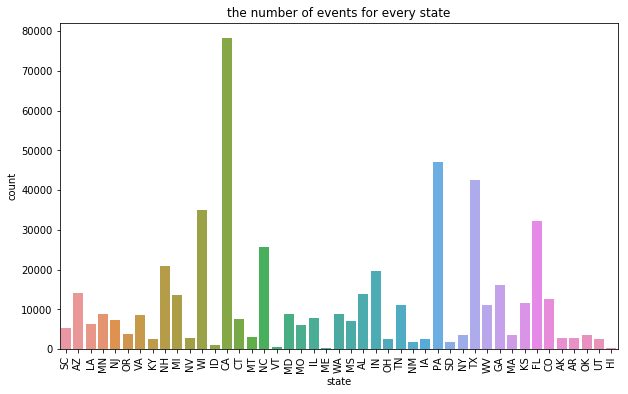

In [30]:
#plot number of users for each level 
df_state = logs_new.groupby('state').count().toPandas()
fig, ax = plt.subplots(figsize =(10,6))
g = sns.barplot(x="state", y="count", data=df_state)
plt.setp(g.get_xticklabels(), rotation=90)
plt.title('the number of events for every state')

from exploring the states that users lives in, we see that CA state has the highest number of users then PA, TX,FL,WI,NC respectively, and many of the states has a very few number of users.


#### Exploring the categorical variables (level, page, method, gender, auth)


Text(0.5,1,'the number of events for every level')

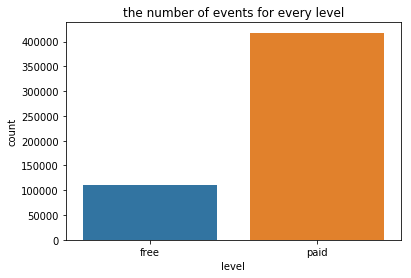

In [31]:
#plot number of users for each level 
df_level = logs_new.groupby('level').count().toPandas()
sns.barplot(x="level", y="count", data=df_level)
plt.title('the number of events for every level')

Text(0.5,1,'the number of events for every method')

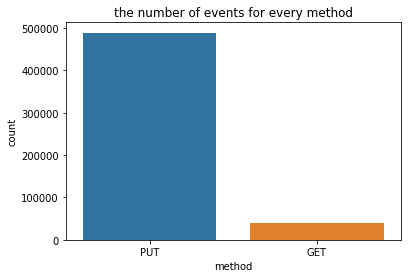

In [32]:
#plot number of users for each method
df_level = logs_new.groupby('method').count().toPandas()
sns.barplot(x="method", y="count", data=df_level)
plt.title('the number of events for every method')

Text(0.5,1,'the number of events for every gender')

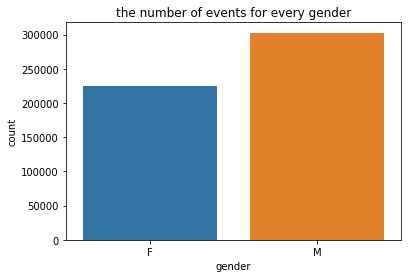

In [33]:
#plot number of users for each gender
df_level = logs_new.groupby('gender').count().toPandas()
sns.barplot(x="gender", y="count", data=df_level)
plt.title('the number of events for every gender')

        auth   count
0  Cancelled      99
1  Logged In  527906


Text(0.5,1,'the number of events for every authentication')

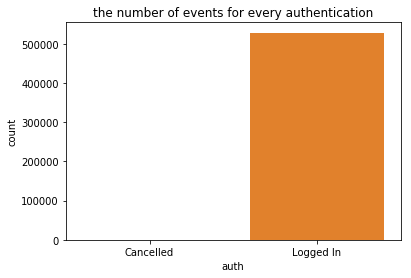

In [34]:
#plot number of users for each authintication
df_level = logs_new.groupby('auth').count().toPandas()
print(df_level)
sns.barplot(x="auth", y="count", data=df_level)
plt.title('the number of events for every authentication')

Text(0.5,1,'the number of events for every page')

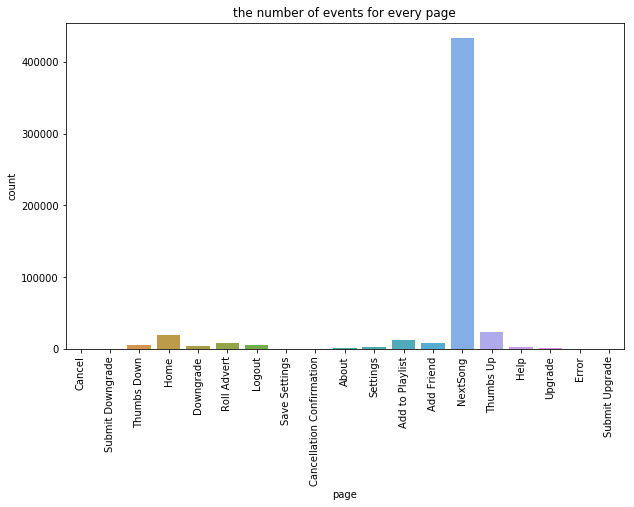

In [35]:
#plot number of users for each level 
df_level = logs_new.groupby('page').count().toPandas()
fig, ax = plt.subplots(figsize =(10,6))
g = sns.barplot(x="page", y="count", data=df_level, ax=ax)
plt.setp(g.get_xticklabels(), rotation=90)
plt.title('the number of events for every page')


From the above visualizations, we notice that:

1. The `paid` level has higher number of events than the free level.
2. There are some `states` has much more users than others, that CA has the highest number of users.
3. There's no big diffrence between females and males (`gender`) in their behavior on the app.
4. The `Logged in` authentication has much more events than the logged out or any other authentication type.
5. The `NextSong` page has got the highest number of events.

Now, that we will focus on the events that the user churn either by downgrading or by cancellation.

### Define Churn
I will create a column `Churn` to use as the label for the model. I will use the `Cancellation Confirmation` events to define `churn` feature, which happen for both paid and free users. 

In [36]:
# Extract the userIds who have got the cancellation confirmation or DownGrade pages to define the churn column
churn = logs_new.filter((logs_new.page == 'Cancellation Confirmation') | (logs_new.page == 'Downgrade')).select('userId').dropDuplicates().collect()
churn_list = [row['userId'] for row in churn]


In [37]:
logs_churn = logs_new.withColumn("churn", logs_new.userId.isin(churn_list))

In [38]:
#Take a look at the dataframe with churn
logs_churn.head(n=5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', state='TX', churn=True),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98', state='TX', churn=True),
 Row(artist='Afroman', auth

### Explore Data
Now, it is the time to perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. 

In [39]:
#showing the number of churned users and stayed users
logs_churn.dropDuplicates(["userId"]).groupby('churn').count().sort('churn').show()

+-----+-----+
|churn|count|
+-----+-----+
|false|  122|
| true|  326|
+-----+-----+



Now it is the time to explore the dataset by comparing between churned users and stayed users to be able to extract the best features that are suitable for applying machine learning algorithms and techniques.

#### Explore categorical columns(gender, level, auth, method)

Text(0.5,1,'the number of users for churned and stayed users based on gender')

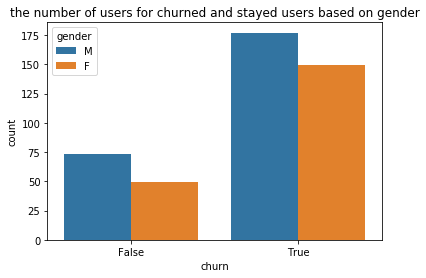

In [40]:
# Showing the number of churned users and stayed users according to gender feature
gender_churn = logs_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=gender_churn)
plt.title('the number of users for churned and stayed users based on gender')

Text(0.5,1,'the number of users for churned and stayed users based on level')

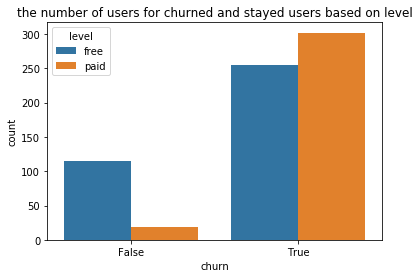

In [41]:
level_churn = logs_churn.dropDuplicates(["userId", "level"]).groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='level', data=level_churn)
plt.title('the number of users for churned and stayed users based on level')

It seems that the churned users have got a very high percent from the paid level events compared to the stayed users

Text(0.5,1,'the number of users for churned and stayed users based on authentication')

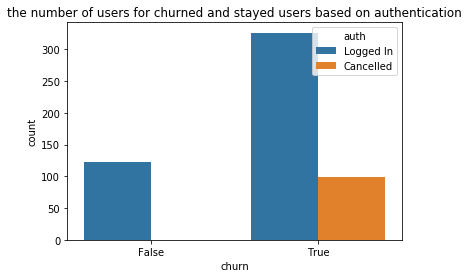

In [42]:
auth_churn = logs_churn.dropDuplicates(["userId", "auth"]).groupby(["churn", "auth"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='auth', data=auth_churn)
plt.title('the number of users for churned and stayed users based on authentication')

Text(0.5,1,'the number of users for churned and stayed users based on method')

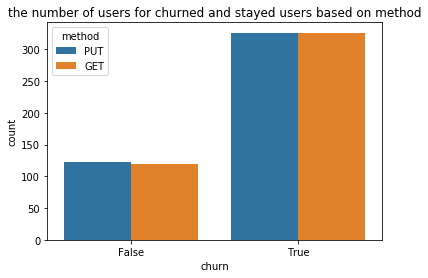

In [43]:
method_churn = logs_churn.dropDuplicates(["userId", "method"]).groupby(["churn", "method"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='method', data=method_churn)
plt.title('the number of users for churned and stayed users based on method')

#### explore the page column

In [44]:
#define a new dataframe with churned users only
df_churned = logs_churn.filter(logs_churn.churn == True)
df_churned.count()

496211

In [45]:
#define new dataframe with stayed users only
df_stayed = logs_churn.filter(logs_churn.churn != True)
df_stayed.count()

31794

Text(0.5,1,'the number of events for every page for stayed users')

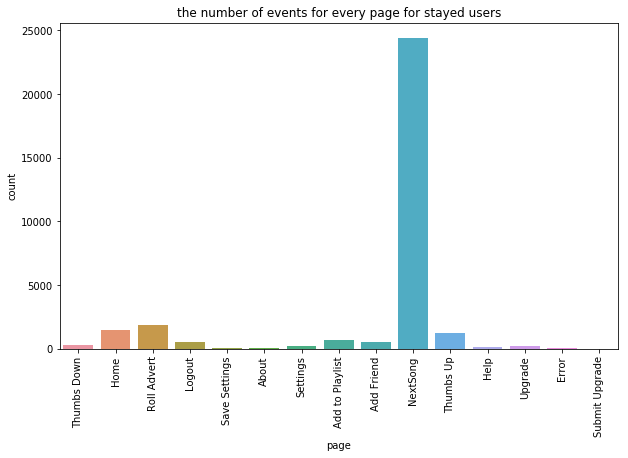

In [46]:
#explore the pages which stayed users use
df_level = df_stayed.groupby('page').count().toPandas()
fig, ax = plt.subplots(figsize =(10,6))
g = sns.barplot(x="page", y="count", data=df_level, ax=ax)
plt.setp(g.get_xticklabels(), rotation=90)
plt.title('the number of events for every page for stayed users')


Text(0.5,1,'the number of events for every page for churned users')

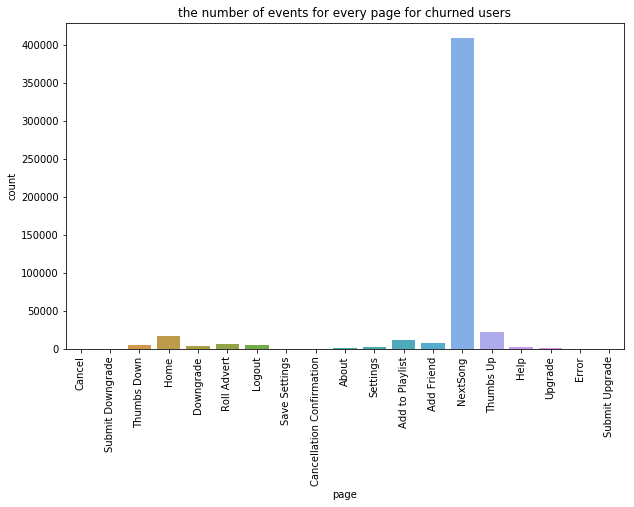

In [47]:
#explore the pages which stayed users use
df_level = df_churned.groupby('page').count().toPandas()
fig, ax = plt.subplots(figsize =(10,6))
g = sns.barplot(x="page", y="count", data=df_level, ax=ax)
plt.setp(g.get_xticklabels(), rotation=90)
plt.title('the number of events for every page for churned users')


We can see that the stayed users don't use `Downgrade` or `cancellation confirmation` pages, as what we specify.

#### Explore number of events, sessions, songs, artists, time period(ts)

From these features, I will explore the behavour of churned users and stayed users to find new features

In [48]:
#Take a look at the statistics for the number of events per churned user
churned_count = df_churned.groupby('userId').count().toPandas()
churned_count.describe()

,count
count,326.000000
mean,1522.119632
std,1470.538794
min,13.000000
25%,504.750000
50%,1097.500000
75%,2038.750000
max,9767.000000


In [267]:
#Take a look at the statistics for the number of events per stayed user
stayed_count = df_stayed.groupby('userId').count().toPandas()
stayed_count.describe()

,count
count,122.000000
mean,260.606557
std,256.382448
min,3.000000
25%,84.500000
50%,175.000000
75%,366.000000
max,1853.000000


From the above exploration, we see that the average number of events for churned users is much more than the average number of events for stayed users, we can notice this difference for all statistics from the above tables.

In [272]:
#number of sessions per churned user and showing statistics
logs_session = df_churned.select('userId', 'sessionId').dropDuplicates()\
.groupby('userId').count().selectExpr("userId","count as session_count")
logs_session.describe('session_count').show()

+-------+------------------+
|summary|     session_count|
+-------+------------------+
|  count|               326|
|   mean| 16.17484662576687|
| stddev|14.166377718694058|
|    min|                 1|
|    max|                92|
+-------+------------------+



In [273]:
#number of sessions per stayed user and showing statistics
logs_session = df_stayed.select('userId', 'sessionId').dropDuplicates()\
.groupby('userId').count().selectExpr("userId","count as session_count")
logs_session.describe('session_count').show()

+-------+-----------------+
|summary|    session_count|
+-------+-----------------+
|  count|              122|
|   mean|6.614754098360656|
| stddev|5.896415385795218|
|    min|                1|
|    max|               32|
+-------+-----------------+



from these statistics we can notice that the mean and standard deviation for churned users are(16.17, 14.17), and for stayed users are (6.6, 5.9), which means there is a big difference in this feature

In [275]:
#number of songs per session for churned users
logs_songs = df_churned.groupby('userId', 'sessionId').count().groupby('userId').agg(F.avg('count'))
logs_songs = logs_songs.withColumnRenamed("avg(count)", "avgsongs_session")
logs_songs.describe('avgsongs_session').show()

+-------+------------------+
|summary|  avgsongs_session|
+-------+------------------+
|  count|               326|
|   mean| 93.28935695207232|
| stddev|43.797859601925815|
|    min|              13.0|
|    max|             423.0|
+-------+------------------+



In [50]:
#number of songs per session for stayed users
logs_songs = df_stayed.groupby('userId', 'sessionId').count().groupby('userId').agg(F.avg('count'))
logs_songs = logs_songs.withColumnRenamed("avg(count)", "avgsongs_session")
logs_songs.describe('avgsongs_session').show()

+-------+-----------------+
|summary| avgsongs_session|
+-------+-----------------+
|  count|              122|
|   mean|40.24680799040785|
| stddev|20.74459104639016|
|    min|              3.0|
|    max|            128.0|
+-------+-----------------+



from the above statistics we can see the difference in the mean and standard deviation betwwen the churned and stayed users, that they are (93.3, 44) for churned users, and (40.2, 21) for stayed users.

In [51]:
#number of artists per churned user
logs_artists = df_churned.select('userId', 'artist').dropDuplicates()\
.groupby('userId').count().withColumnRenamed('count', 'artists_count')
logs_artists.describe('artists_count').show()

+-------+-----------------+
|summary|    artists_count|
+-------+-----------------+
|  count|              326|
|   mean|840.3895705521472|
| stddev|640.3063822518333|
|    min|                8|
|    max|             3508|
+-------+-----------------+



In [52]:
#number of artists per stayed user
logs_artists = df_stayed.select('userId', 'artist').dropDuplicates()\
.groupby('userId').count().withColumnRenamed('count', 'artists_count')
logs_artists.describe('artists_count').show()

+-------+------------------+
|summary|     artists_count|
+-------+------------------+
|  count|               122|
|   mean| 177.9016393442623|
| stddev|154.60370077980346|
|    min|                 2|
|    max|              1005|
+-------+------------------+



In [60]:
#number of thumbs up for churned users 
thumbs_up = df_churned.filter(logs_churn.page == 'Thumbs Up').groupby('userId').count()
thumbs_up = thumbs_up.withColumnRenamed('count', 'thumbs_up_count')
thumbs_up.describe('thumbs_up_count').show()

+-------+-----------------+
|summary|  thumbs_up_count|
+-------+-----------------+
|  count|              325|
|   mean|69.41230769230769|
| stddev|75.38098195596669|
|    min|                1|
|    max|              506|
+-------+-----------------+



In [62]:
#number of thumbs down for churned users
thumbs_down = df_churned.filter(logs_churn.page == 'Thumbs Down').groupby('userId').count()
thumbs_down = thumbs_down.withColumnRenamed('count', 'thumbs_down_count')
thumbs_down.describe('thumbs_down_count').show()

+-------+------------------+
|summary| thumbs_down_count|
+-------+------------------+
|  count|               309|
|   mean|14.838187702265373|
| stddev|14.185678412736856|
|    min|                 1|
|    max|                80|
+-------+------------------+



In [65]:
#number of thumbs up and down for stayed users 
thumbs_up = df_stayed.filter(df_stayed.page == 'Thumbs Up').groupby('userId').count()
thumbs_up = thumbs_up.withColumnRenamed('count', 'thumbs_up_count')
thumbs_up.describe('thumbs_up_count').show()

+-------+------------------+
|summary|   thumbs_up_count|
+-------+------------------+
|  count|               114|
|   mean|11.114035087719298|
| stddev|11.407774690840807|
|    min|                 1|
|    max|                80|
+-------+------------------+



In [66]:
#number of thumbs down for stayed users
thumbs_down = df_stayed.filter(df_stayed.page == 'Thumbs Down').groupby('userId').count()
thumbs_down = thumbs_down.withColumnRenamed('count', 'thumbs_down_count')
thumbs_down.describe('thumbs_down_count').show()

+-------+-----------------+
|summary|thumbs_down_count|
+-------+-----------------+
|  count|               80|
|   mean|            4.075|
| stddev|5.321974983172974|
|    min|                1|
|    max|               42|
+-------+-----------------+



In [67]:
#the time period for churned users-ts
logs_avg_time = df_churned.groupby('userId', 'sessionId')\
.agg(((F.max(df_churned.ts) - F.min(df_churned.ts)) / (1000*60)).alias('period_time'))

logs_avg_time = logs_avg_time.groupby('userId').agg(F.avg(logs_avg_time.period_time).alias('avg_period_session')).sort('userId')
logs_avg_time.describe('avg_period_session').show()

+-------+------------------+
|summary|avg_period_session|
+-------+------------------+
|  count|               326|
|   mean|318.30009868043226|
| stddev|159.69049574662736|
|    min|              29.9|
|    max|            1502.4|
+-------+------------------+



In [68]:
#the time period for churned users-ts
logs_avg_time = df_stayed.groupby('userId', 'sessionId')\
.agg(((F.max(df_stayed.ts) - F.min(df_stayed.ts)) / (1000*60)).alias('period_time'))

logs_avg_time = logs_avg_time.groupby('userId').agg(F.avg(logs_avg_time.period_time).alias('avg_period_session')).sort('userId')
logs_avg_time.describe('avg_period_session').show()

+-------+------------------+
|summary|avg_period_session|
+-------+------------------+
|  count|               122|
|   mean| 132.8161523430135|
| stddev| 77.86187929463007|
|    min|13.166666666666666|
|    max|415.31666666666666|
+-------+------------------+



From these all statisitics, the mean and standard deviations for churned users are different from the stayed users, so these features will help us in building our models.

#### Explore Location

Text(0.5,1,'the number of events for every state')

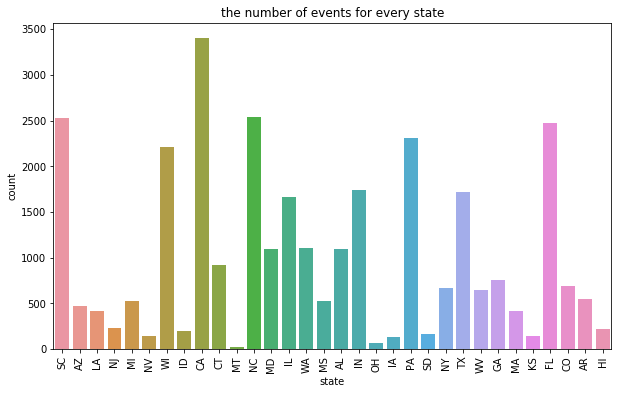

In [269]:
#plot number of events for every state for stayed users
df_state = df_stayed.groupby('state').count().toPandas()
fig, ax = plt.subplots(figsize =(10,6))
g = sns.barplot(x="state", y="count", data=df_state)
plt.setp(g.get_xticklabels(), rotation=90)
plt.title('the number of events for every state for stayed users')

Text(0.5,1,'the number of events for every state')

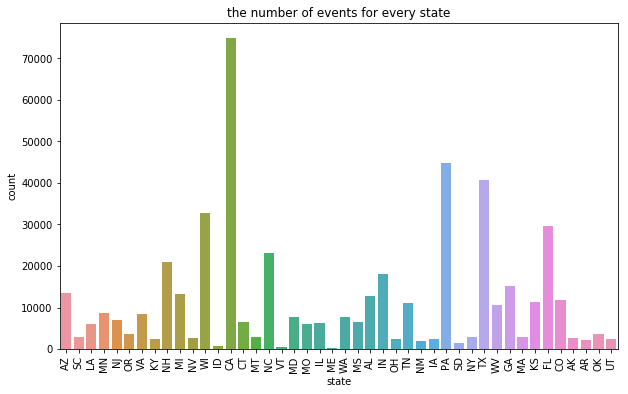

In [270]:
#plot number of events for every state for churned users 
df_state = df_churned.groupby('state').count().toPandas()
fig, ax = plt.subplots(figsize =(10,6))
g = sns.barplot(x="state", y="count", data=df_state)
plt.setp(g.get_xticklabels(), rotation=90)
plt.title('the number of events for every state for churned users')

from comparing between the two plots, we can notice that there is a diffrence between the two distributions for churned users and stayed users in the locations in us states.

### Conclusion of EDA

From the EDA I could see the big diffrence between the behavour of churned users and stayed users, for all features I created in this section there is a diffrence that will help us in building machine learning models so I will choose these features in building our models:
1. Gender
2. Level (Paid or free)
3. Number of sessions per user
4. Number of songs per session
5. Number of artists per user
6. Number of thumbs up and down per user
7. Average time for every session per user
8. State(Location)

## Feature Engineering


Now, I have been built intuition abut the data, it is the time to built the features to train machine learning model

### Feature 1 : Gender

I will convert gender feature to be numeric to use it in my model

In [214]:
logs_churn = logs_churn.replace(["M", "F"], ["0", "1"], "gender")
logs_gender = logs_churn.select('userId',logs_churn.gender.cast("int"))


In [215]:
logs_gender.show()

+------+------+
|userId|gender|
+------+------+
|   293|     0|
|    98|     0|
|   179|     0|
|   179|     0|
|   246|     1|
|   163|     1|
|   179|     0|
|   175|     1|
|   100|     0|
|   100|     0|
|   163|     1|
|   246|     1|
|   179|     0|
|    39|     1|
|   163|     1|
|   179|     0|
|    98|     0|
|   175|     1|
|    98|     0|
|   100|     0|
+------+------+
only showing top 20 rows



### Feature 2 : Paid or Free user

In [216]:
logs_level = logs_churn.groupby("userId", "level").agg(F.max(logs_churn.ts).alias("recent_time")).sort("userId")

logs_level.show()

+------+-----+-------------+
|userId|level|  recent_time|
+------+-----+-------------+
|    10| paid|1539055364000|
|   100| paid|1543606468000|
|   100| free|1538477683000|
|100001| free|1538491859000|
|100002| free|1541146660000|
|100002| paid|1541146209000|
|100003| paid|1541661592000|
|100003| free|1540678787000|
|100004| free|1539511980000|
|100005| free|1538820679000|
|100006| free|1543622360000|
|100006| paid|1541636185000|
|100007| free|1543483022000|
|100007| paid|1543451434000|
|100008| paid|1543622405000|
|100009| free|1541369693000|
|100009| paid|1543408478000|
|100010| free|1539254318000|
|100011| paid|1542839733000|
|100011| free|1542830547000|
+------+-----+-------------+
only showing top 20 rows



In [217]:
w = Window.partitionBy('userId')
logs_level = logs_level.withColumn('maxB', F.max('recent_time').over(w))\
    .where(F.col('recent_time') == F.col('maxB'))\
    .drop('maxB')
logs_level = logs_level.select('userId', 'level')
logs_level.show()

+------+-----+
|userId|level|
+------+-----+
|    10| paid|
|   100| paid|
|100001| free|
|100002| free|
|100003| paid|
|100004| free|
|100005| free|
|100006| free|
|100007| free|
|100008| paid|
|100009| paid|
|100010| free|
|100011| paid|
|100012| free|
|100013| free|
|100014| paid|
|100015| free|
|100016| paid|
|100017| free|
|100018| free|
+------+-----+
only showing top 20 rows



### Feature 3 : number of sessions per user

In [218]:
logs_session = logs_churn.select('userId', 'sessionId').dropDuplicates()\
.groupby('userId').count().selectExpr("userId","count as session_count")
logs_session.show()

+------+-------------+
|userId|session_count|
+------+-------------+
|200002|            5|
|   296|            5|
|100010|            2|
|   125|            3|
|     7|           15|
|   124|           17|
|    51|            5|
|200037|            7|
|   205|            5|
|   169|            8|
|   272|            2|
|   282|           29|
|    15|           18|
|    54|            8|
|   234|           26|
|   232|           23|
|200043|           12|
|   155|            4|
|100014|            4|
|   154|            4|
+------+-------------+
only showing top 20 rows



#### Feature 4 : Number of songs per session

In [219]:
logs_songs = logs_churn.groupby('userId', 'sessionId').count().groupby('userId').agg(F.avg('count'))
logs_songs = logs_songs.withColumnRenamed("avg(count)", "avgsongs_session")

In [220]:
logs_songs.show()

+------+------------------+
|userId|  avgsongs_session|
+------+------------------+
|200002|              79.0|
|   296|              30.4|
|100010|              68.5|
|   125|              28.0|
|     7|              40.0|
|   124|126.82352941176471|
|    51|              65.6|
|200037|22.142857142857142|
|   205|             248.8|
|   169|            18.625|
|   272|              65.5|
|   282|110.03448275862068|
|    15|120.72222222222223|
|    54|              78.0|
|   234| 77.73076923076923|
|   232|101.08695652173913|
|200043| 67.33333333333333|
|   155|              43.0|
|100014|             101.5|
|   154|              31.5|
+------+------------------+
only showing top 20 rows



#### Feature 5: Number of artists per user

In [221]:
logs_artists = logs_churn.select('userId', 'artist').dropDuplicates()\
.groupby('userId').count().withColumnRenamed('count', 'artists_count')

In [222]:
logs_artists.show()

+------+-------------+
|userId|artists_count|
+------+-------------+
|   296|          109|
|100010|           95|
|200002|          288|
|   125|           62|
|   124|         1241|
|    51|          234|
|     7|          408|
|200037|          115|
|   205|          804|
|   169|          112|
|   272|           94|
|    54|          439|
|   234|         1174|
|   282|         1642|
|    15|         1287|
|   232|         1281|
|   155|          134|
|200043|          513|
|   132|          107|
|100014|          293|
+------+-------------+
only showing top 20 rows



#### Feature 5: average time per session for every user

In [223]:
logs_avg_time = logs_churn.groupby('userId', 'sessionId')\
.agg(((F.max(logs_churn.ts) - F.min(logs_churn.ts)) / (1000*60)).alias('period_time'))

logs_avg_time = logs_avg_time.groupby('userId').agg(F.avg(logs_avg_time.period_time).alias('avg_period_session')).sort('userId')

In [224]:
logs_avg_time.show()

+------+------------------+
|userId|avg_period_session|
+------+------------------+
|    10|            1502.4|
|   100|350.47777777777776|
|100001|137.66111111111113|
|100002|          150.2625|
|100003|296.92777777777775|
|100004|222.09666666666664|
|100005|139.03333333333333|
|100006| 235.9766666666667|
|100007|288.90138888888885|
|100008| 262.2944444444444|
|100009|402.92999999999995|
|100010|           210.375|
|100011|208.92583333333337|
|100012| 72.28055555555555|
|100013| 75.41666666666667|
|100014|           348.975|
|100015|126.88076923076923|
|100016|113.63333333333333|
|100017|270.40833333333336|
|100018| 258.6166666666667|
+------+------------------+
only showing top 20 rows



#### Feature 8: Number of thumbs up and thumbs down per user

In [53]:
thumbs_up = logs_churn.filter(logs_churn.page == 'Thumbs Up').groupby('userId').count()
thumbs_up = thumbs_up.withColumnRenamed('count', 'thumbs_up_count')

In [54]:
thumbs_down = logs_churn.filter(logs_churn.page == 'Thumbs Down').groupby('userId').count()
thumbs_down = thumbs_down.withColumnRenamed('count', 'thumbs_down_count')

In [55]:
thumbs_up.show(n=5)

+------+---------------+
|userId|thumbs_up_count|
+------+---------------+
|   296|              8|
|100010|              4|
|200002|             15|
|   125|              3|
|    51|             16|
+------+---------------+
only showing top 5 rows



In [56]:
thumbs_down.show(n=5)

+------+-----------------+
|userId|thumbs_down_count|
+------+-----------------+
|100010|                3|
|200002|                5|
|   125|                1|
|   124|               15|
|    51|                1|
+------+-----------------+
only showing top 5 rows



#### Feature 9: state

In [229]:
logs_location = logs_churn.select('userId', 'state').dropDuplicates().sort('userId')


In [230]:
logs_location.show(n=5)

+------+-----+
|userId|state|
+------+-----+
|    10|   MS|
|   100|   TX|
|100001|   FL|
|100002|   CA|
|100003|   FL|
+------+-----+
only showing top 5 rows



#### Label: churn

In [231]:
churn = logs_churn.select("userId", "churn").dropDuplicates()
churn = churn.select("userId", churn.churn.cast("int"))


In [232]:
churn.show(n=5)

+------+-----+
|userId|churn|
+------+-----+
|    73|    0|
|    69|    1|
|    19|    0|
|   139|    1|
|   300|    1|
+------+-----+
only showing top 5 rows



In [233]:
#define list to save all features in
dataframes = []
dataframes.append(logs_gender)
dataframes.append(logs_session)
dataframes.append(logs_level)
dataframes.append(logs_songs)
dataframes.append(logs_artists)
dataframes.append(logs_avg_time)
dataframes.append(thumbs_up)
dataframes.append(thumbs_down)
dataframes.append(logs_location)
dataframes.append(churn)

#extract the userids from the dataset
df = logs_churn.select("userId").dropDuplicates()

#join every feature with the original userIds
for dataframe in dataframes:
    dataframe = dataframe.withColumnRenamed("userId", "Id")
    df = df.join(dataframe, df.userId == dataframe.Id, "left").drop("Id")

df = df.dropDuplicates().sort('userId')
df = df.fillna(0, subset = ['thumbs_up_count'])
df = df.fillna(0, subset =['thumbs_down_count'])
df.persist()

DataFrame[userId: string, gender: int, session_count: bigint, level: string, avgsongs_session: double, artists_count: bigint, avg_period_session: double, thumbs_up_count: bigint, thumbs_down_count: bigint, state: string, churn: int]

In [234]:
#checking the missing values in thumbs_up and thumbs_down columns
print('The number of missing values in thumbs_up_count column:')

print(df.select('thumbs_up_count').withColumn('isNull_up',F.col('thumbs_up_count')\
                                              .isNull()).where('isNull_up = True').count())

print('The number of missing values in thumbs_down_count column:')

print(df.select('thumbs_down_count').withColumn('isNull_down',F.col('thumbs_down_count')\
                                              .isNull()).where('isNull_down = True').count())


The number of missing values in thumbs_up_count column:
0
The number of missing values in thumbs_down_count column:
0


In [235]:
df.show(n=3)

+------+------+-------------+-----+------------------+-------------+------------------+---------------+-----------------+-----+-----+
|userId|gender|session_count|level|  avgsongs_session|artists_count|avg_period_session|thumbs_up_count|thumbs_down_count|state|churn|
+------+------+-------------+-----+------------------+-------------+------------------+---------------+-----------------+-----+-----+
|    10|     0|            1| paid|             423.0|          307|            1502.4|             17|                1|   MS|    1|
|   100|     0|           39| paid|102.53846153846153|         1964|350.47777777777776|            143|               37|   TX|    1|
|100001|     1|            3| free|44.666666666666664|           94|137.66111111111113|              5|                1|   FL|    1|
+------+------+-------------+-----+------------------+-------------+------------------+---------------+-----------------+-----+-----+
only showing top 3 rows



This is the function for feature engineering :

In [100]:
def feature_ml(df):
    '''
    This function for building the new dataframe that handles the best features that are suitable
    for building machine learning models to predict if the user will churn or not
    
    INPUT:
    df -> the cleaned dataframe handles all features in the original dataset
    
    OUTPUT:
    df_new -> the new datafrmae with the new feature that are suitable for building ML models
    '''
    
    #gender feature
    df = df.replace(["M", "F"], ["0", "1"], "gender")
    logs_gender = df.select('userId',df.gender.cast("int"))
    
    #level feature
    logs_level = df.groupby("userId", "level").agg(F.max(df.ts).alias("recent_time")).sort("userId")
    w = Window.partitionBy('userId')
    logs_level = logs_level.withColumn('maxB', F.max('recent_time').over(w))\
        .where(F.col('recent_time') == F.col('maxB'))\
        .drop('maxB')
    logs_level = logs_level.select('userId', 'level')
    
    #number of sessions per user feature
    logs_session = df.select('userId', 'sessionId').dropDuplicates()\
    .groupby('userId').count().selectExpr("userId","count as session_count")
    
    #number of songs per session for every user feature
    logs_songs = df.groupby('userId', 'sessionId').count().groupby('userId').agg(F.avg('count'))
    logs_songs = logs_songs.withColumnRenamed("avg(count)", "avgsongs_session")
    
    #number of artists per user
    logs_artists = df.select('userId', 'artist').dropDuplicates()\
    .groupby('userId').count().withColumnRenamed('count', 'artists_count')
    
    #average time per session for every user
    logs_avg_time = df.groupby('userId', 'sessionId')\
    .agg(((F.max(df.ts) - F.min(df.ts)) / (1000*60)).alias('period_time'))

    logs_avg_time = logs_avg_time.groupby('userId').agg(F.avg(logs_avg_time.period_time).alias('avg_period_session')).sort('userId')
    
    #number of thumbs up and thumbs down per user
    thumbs_up = df.filter(df.page == 'Thumbs Up').groupby('userId').count()
    thumbs_up = thumbs_up.withColumnRenamed('count', 'thumbs_up_count')
    
    thumbs_down = df.filter(df.page == 'Thumbs Down').groupby('userId').count()
    thumbs_down = thumbs_down.withColumnRenamed('count', 'thumbs_down_count')
    
    #us-state feature
    logs_location = df.select('userId', 'state').dropDuplicates().sort('userId')
    
    #convert label to integer type
    churn = df.select("userId", "churn").dropDuplicates()
    churn = churn.select("userId", churn.churn.cast("int"))


    #define list to save all features in
    dataframes = []
    dataframes.append(logs_gender)
    dataframes.append(logs_session)
    dataframes.append(logs_level)
    dataframes.append(logs_songs)
    dataframes.append(logs_artists)
    dataframes.append(logs_avg_time)
    dataframes.append(thumbs_up)
    dataframes.append(thumbs_down)
    dataframes.append(logs_location)
    dataframes.append(churn)

    #extract the userids from the dataset
    df = df.select("userId").dropDuplicates()

    #join every feature with the original userIds
    for dataframe in dataframes:
        dataframe = dataframe.withColumnRenamed("userId", "Id")
        df = df.join(dataframe, df.userId == dataframe.Id, "left").drop("Id")

    df_new = df.dropDuplicates().sort('userId')
    df_new = df_new.fillna(0, subset = ['thumbs_up_count'])
    df_new = df_new.fillna(0, subset =['thumbs_down_count'])
    
    return df_new
    


In [238]:
#write the machine learning data on a new file
df.write.save('ml_data_medium1.csv', format="csv", header=True)


In [69]:
#read the data from the file
df = spark.read.csv('ml_data_medium1.csv', header=True)
df.persist()

DataFrame[userId: string, gender: string, session_count: string, level: string, avgsongs_session: string, artists_count: string, avg_period_session: string, thumbs_up_count: string, thumbs_down_count: string, state: string, churn: string]

In [70]:
columns = df.describe().columns[1:]
for col in columns:
    print(col, df.select(['userId']).where(df[col].isNull()).count())

userId 0
gender 0
session_count 0
level 0
avgsongs_session 0
artists_count 0
avg_period_session 0
thumbs_up_count 0
thumbs_down_count 0
state 0
churn 0


In [71]:
#convert the features types for numeric values from string to float
numeric_features = ['session_count', 'avgsongs_session', 'artists_count', 'thumbs_up_count','thumbs_down_count', 'churn']
for feature in numeric_features:
    
    df = df.withColumn('cast_'+feature, df[feature].cast('float') )
    df = df.drop(feature)
    
df = df.withColumnRenamed('cast_churn', 'label')    

Now our datasets is ready for applying machine learning techinques like transformation, estimation, validation, and evaluation

## Modeling

### Split into Train, Test, and Validation Sets

In [72]:
#split dataset into train-60% ,test-20% ,validation-20%
train, test_valid = df.randomSplit([0.6, 0.4], seed = 42)
test, validation = test_valid.randomSplit([0.5, 0.5], seed = 42)


### Create Machine Learning Pipelines

In [95]:
index = SparkContext.accumulator(0,0)
def add_index():
    global index
    index += 1

In [98]:
def ml_pipeline(train, test, validation):
    '''
    This function is for building machine learning pipeline, fitting the model on train dataset, 
    and evaluating the pipeline on train dataset and test dataset using f1 score and accuracy
    
    INPUT:
    train ->  the train dataset which is 60% from all dataset
    test -> the test dataset which is 20% from all dataset
    validation -> the validation dataset which is 20% from all dataset
    
    OUTPUT:
    printing the f1 score and accuary for all estimators(random forest, logistic regressio, gradient boosting)
    
    accuracy_list -> list handles the accuacy for all estimators on test dataset
    f1_list -> list handles the f1 score for all estimators on test dataset
    
    '''
    
    accuracy_list = []
    f1_list = []
    
    gender_indexer = StringIndexer(inputCol="gender", outputCol="genderindex", handleInvalid = 'skip')
    state_indexer = StringIndexer(inputCol = "state", outputCol = "stateindex", handleInvalid = 'skip')
    level_indexer = StringIndexer(inputCol = "level", outputCol = "levelindex", handleInvalid = 'skip')

    # maps a column of category indices to a column of binary vectors
    #https://spark.apache.org/docs/2.3.0/api/java/index.html?org/apache/spark/ml/feature/OneHotEncoderEstimator.html

    encoder = OneHotEncoderEstimator(inputCols=["genderindex", "levelindex", "stateindex"],
                                       outputCols=["genderV", "levelV", "stateV"], handleInvalid = 'keep')

    # create vector of features
    features = ['genderV', 'levelV', 'stateV', 'cast_session_count', 'cast_avgsongs_session',
                'cast_artists_count', 'cast_thumbs_up_count', 'cast_thumbs_down_count']

    #combine the features into a vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    
    #normalize the numeric features
    scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")

    
    # initialize random forest, logistic regression, gradient boosting classifiers
    rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10)
    lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial", labelCol="label", featuresCol="scaled_features")
    gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)
    
    estimators = [rf, lr, gbt]
    names = ['random forest', 'logistic regression', 'gradient boosting']
    
    for estimator in estimators:
        
        # assemble pipeline
        pipeline = Pipeline(stages = [gender_indexer, state_indexer, level_indexer, encoder, assembler,scalar, estimator])
        model = pipeline.fit(train)
        pred_train = model.transform(train)
        pred_test = model.transform(test)
        
        #evaluate machine learning pipeline performance on train dataset
        
        f1_eval_train = MulticlassClassificationEvaluator(metricName="f1")
        print('F1 score on train dataset using {} classifier is {}. '.format(names[index.value], f1_eval_train.evaluate(pred_train))) 
        
        acc_train = pred_train.filter(pred_train.label == pred_train.prediction).count() / pred_train.count()
        print('accuracy on train data using {} classifier is {} '.format(names[index.value], acc_train))
              
        #evaluate the model using ROC metric
        eval_roc_train = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="label")
        print("The area under ROC for train set using {} classifier is {}".format(names[index.value], eval_roc_train.evaluate(pred_train)))
              
        print('--------')
        #evaluate machine learning pipeline performance on test dataset
        
        f1_eval_test = MulticlassClassificationEvaluator(metricName="f1")
        print('F1 score on test dataset using {} classifier is {}. '.format(names[index.value], f1_eval_test.evaluate(pred_test)))
        f1_list.append(f1_eval_test.evaluate(pred_test))
        
        acc_test = pred_test.filter(pred_test.label == pred_test.prediction).count() / pred_test.count()
        print('accuracy on test data using {} classifier is {}'.format(names[index.value], acc_test))
        accuracy_list.append(acc_test)
        
        #evaluate the model using ROC metric
        eval_roc_test=BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="label")
        print("The area under ROC for test set using {} classifier is {}".format(names[index.value], eval_roc_test.evaluate(pred_test)))
        
        print('-------------------------------------------------------------------------------')
        print('-------------------------------------------------------------------------------')
       
        add_index()
    return accuracy_list, f1_list

In [97]:
accuracy_list, f1_list = ml_pipeline(train, test, validation)

F1 score on train dataset using random forest classifier is 0.923891510304238. 
accuracy on train data using random forest classifier is 0.9250936329588015 
The area under ROC for train set using random forest classifier is 0.8854850746268657
--------
F1 score on test dataset using random forest classifier is 0.8041695146958305. 
accuracy on test data using random forest classifier is 0.8068181818181818
The area under ROC for test set using random forest classifier is 0.7729885057471265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
F1 score on train dataset using logistic regression classifier is 0.6415962915734348. 
accuracy on train data using logistic regression classifier is 0.7490636704119851 
The area under ROC for train set using logistic regression classifier is 0.5
--------
F1 score on test dataset using logistic regression classifier is 0.5236612702366127. 
accura

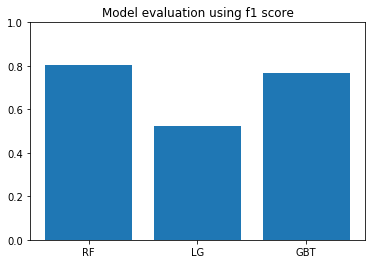

In [76]:
#plot the models evaluation using f1 score to compare between models
fig, ax = plt.subplots(figsize=(6, 4))
models = ['RF', 'LG', 'GBT']
x_pos = np.arange(0, 3)

ax.bar(x_pos, f1_list, tick_label = models)
ax.set_title('Model evaluation using f1 score')

plt.ylim(0, 1)
plt.show()

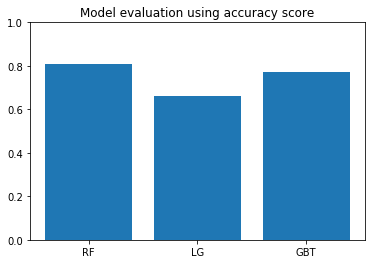

In [77]:
#plot the models evaluation using accuracy score to compare between models
fig, ax = plt.subplots(figsize=(6, 4))
models = ['RF', 'LG', 'GBT']
x_pos = np.arange(0, 3)

ax.bar(x_pos, accuracy_list, tick_label = models)
ax.set_title('Model evaluation using accuracy score')

plt.ylim(0, 1)
plt.show()

### Optimization

Now it is the time to tune hyperparameters for Random Forest, logistic regression, and gradient boosting to optimize the results.

In [78]:
def model_opt(train, test, validation, estimator, paramGrid, name): 
    '''
    This function is for optimizing the estimators using parameter grid builder
    INPUTS:
    
    train ->  the train dataset which is 60% from all dataset
    test -> the test dataset which is 20% from all dataset
    validation -> the validation dataset which is 20% from all dataset
    estimator -> the classifier object
    paramGrid -> the parameter grid builder which handles all parameters
    name -> string handlesthe name of the estimator
    
    OUTPUT:
    printing the f1 score and accuary for the  estimator is used
    
    acc_test ->  handles the accuacy for  the estimator i used on test dataset
    f1_test ->  handles the f1 score for the estimator is used on test dataset
    valid_res -> pandas dataframe handles all parameters is used in grid builder with f1 score
    
    
    '''
    
    gender_indexer = StringIndexer(inputCol="gender", outputCol="genderindex", handleInvalid = 'skip')
    state_indexer = StringIndexer(inputCol = "state", outputCol = "stateindex", handleInvalid = 'skip')
    level_indexer = StringIndexer(inputCol = "level", outputCol = "levelindex", handleInvalid = 'skip')

    # maps a column of category indices to a column of binary vectors
    #https://spark.apache.org/docs/2.3.0/api/java/index.html?org/apache/spark/ml/feature/OneHotEncoderEstimator.html

    encoder = OneHotEncoderEstimator(inputCols=["genderindex", "levelindex", "stateindex"],
                                       outputCols=["genderV", "levelV", "stateV"], handleInvalid = 'keep')

    # create vector of features
    features = ['genderV', 'levelV', 'stateV', 'cast_session_count', 'cast_avgsongs_session',
                'cast_artists_count', 'cast_thumbs_up_count', 'cast_thumbs_down_count']

    #combine the features into a vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    
    #normalize the numeric features
    scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")

    
    # initialize random forest, logistic regression, gradient boosting classifiers
    pipeline = Pipeline(stages = [gender_indexer, state_indexer, level_indexer, encoder, assembler,scalar, estimator])
    
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
    cv = crossval.fit(train)
    Model = cv.bestModel
   
    pred_test = Model.transform(test)
    
    #evaluation on test data for the best model
    f1_eval_test = MulticlassClassificationEvaluator(metricName="f1")
    f1_test = f1_eval_test.evaluate(pred_test)
    print('F1 score on test dataset using {} classifier is {}. '.format(name, f1_test))   
    
    acc_test = pred_test.filter(pred_test.label == pred_test.prediction).count() / pred_test.count()
    print('accuracy on test data using {} classifier is {}'.format(name, acc_test))

    
    # get parameters
    params = [{p.name: v for p, v in m.items()} for m in cv.getEstimatorParamMaps()]

    # convert validation results to pandas dataframe
    valid_res = pd.DataFrame.from_dict([
        {cv.getEvaluator().getMetricName(): metric, **ps} 
        for ps, metric in zip(params, cv.avgMetrics)
    ])
    
    return valid_res, f1_test, acc_test

In [79]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10)
paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20, 50]) \
        .addGrid(rf.maxDepth, [3, 7, 10]) \
        .addGrid(rf.impurity, ['entropy', 'gini'])\
        .build()



In [80]:
valid_rf, f1_rf, acc_rf = model_opt(train, test, validation, rf, paramGrid, 'RandomForest')

F1 score on test dataset using RandomForest classifier is 0.8288293627276678. 
accuracy on test data using RandomForest classifier is 0.8295454545454546


In [81]:
valid_rf

,f1,impurity,maxDepth,numTrees
0,0.843700,entropy,3,10
1,0.854878,gini,3,10
2,0.844488,entropy,7,10
3,0.837643,gini,7,10
4,0.850121,entropy,10,10
5,0.836805,gini,10,10
6,0.854080,entropy,3,20
7,0.846719,gini,3,20
8,0.872244,entropy,7,20
9,0.865492,gini,7,20


In [82]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial", labelCol="label", featuresCol="scaled_features")
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 30, 50]) \
    .addGrid(lr.regParam, [0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.8])\
    .addGrid(lr.family, ['auto'])\
    .build() 

In [83]:
valid_lr, f1_lr, acc_lr = model_opt(train, test, validation, lr, paramGrid, 'Logistic Regression')
valid_lr

F1 score on test dataset using Logistic Regression classifier is 0.8100609068351005. 
accuracy on test data using Logistic Regression classifier is 0.8181818181818182


,elasticNetParam,f1,family,maxIter,regParam
0,0.8,0.806092,auto,10,0.1
1,0.8,0.632522,auto,10,0.3
2,0.8,0.825651,auto,30,0.1
3,0.8,0.632522,auto,30,0.3
4,0.8,0.825651,auto,50,0.1
5,0.8,0.632522,auto,50,0.3


In [84]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 40]) \
    .addGrid(gbt.maxDepth, [2, 3, 5]) \
    .build()    

In [85]:
valid_gbt, f1_gbt, acc_gbt = model_opt(train, test, validation, gbt, paramGrid, 'Gradient Boosting')
valid_gbt

F1 score on test dataset using Gradient Boosting classifier is 0.8206168831168832. 
accuracy on test data using Gradient Boosting classifier is 0.8181818181818182


,f1,maxDepth,maxIter
0,0.858967,2,10
1,0.838801,3,10
2,0.833968,5,10
3,0.856763,2,20
4,0.835401,3,20
5,0.829872,5,20
6,0.852538,2,40
7,0.842747,3,40
8,0.830605,5,40


In [86]:
f1_opt = [f1_rf, f1_lr, f1_gbt]
acc_opt = [acc_rf, acc_lr, acc_gbt]

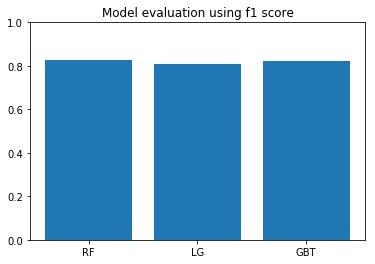

In [87]:
#plot the f1 score for all classfiers used after optimization
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(x_pos, f1_opt, tick_label = models)
ax.set_title('Model evaluation using f1 score')

plt.ylim(0, 1)
plt.show()

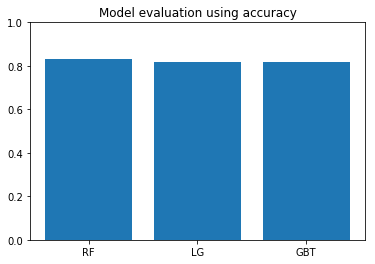

In [88]:
#plot the accuracy score for all classifiers used after optimization
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(x_pos, acc_opt, tick_label = models)
ax.set_title('Model evaluation using accuracy')

plt.ylim(0, 1)
plt.show()

### Using the best model on Validation dataset

In [89]:
gender_indexer = StringIndexer(inputCol="gender", outputCol="genderindex", handleInvalid = 'skip')
state_indexer = StringIndexer(inputCol = "state", outputCol = "stateindex", handleInvalid = 'skip')
level_indexer = StringIndexer(inputCol = "level", outputCol = "levelindex", handleInvalid = 'skip')

# maps a column of category indices to a column of binary vectors
#https://spark.apache.org/docs/2.3.0/api/java/index.html?org/apache/spark/ml/feature/OneHotEncoderEstimator.html

encoder = OneHotEncoderEstimator(inputCols=["genderindex", "levelindex", "stateindex"],
                                 outputCols=["genderV", "levelV", "stateV"], handleInvalid = 'keep')

# create vector of features
features = ['genderV', 'levelV', 'stateV', 'cast_session_count', 'cast_avgsongs_session',
           'cast_artists_count', 'cast_thumbs_up_count', 'cast_thumbs_down_count']

#combine the features into a vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")

    
# initialize random forest, logistic regression, gradient boosting classifiers
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=20, maxDepth =7, impurity='entropy')
pipeline = Pipeline(stages = [gender_indexer, state_indexer, level_indexer, encoder, assembler,scalar, rf])

model = pipeline.fit(train)
pred_valid = model.transform(validation)

#model evaluation
f1_eval_test = MulticlassClassificationEvaluator(metricName="f1")
print('F1 score on validation dataset using random forest classifier is {}. '.format(f1_eval_test.evaluate(pred_valid)))
        
acc_test = pred_valid.filter(pred_valid.label == pred_valid.prediction).count() / pred_valid.count()
print('accuracy on validation data using classifier is {}'.format(acc_test))

F1 score on test dataset using random forest classifier is 0.8074970225036043. 
accuracy on test data using classifier is 0.8023255813953488


## Justification 

In this machine learning journey, I build a machine learning pipeline by creating indexers for categorical variables(giving each value an index), then  maps a column of category indices to a column of binary vectors using one hot encoders, then combine features into vectors, then normalizing the numeric features, then I used three estimators to choose between them the best one based on the metrics used in evaluation.

The main purpose is to predict if the customer will churn or not, the random frest classifier was chosen in this prediction because it gave us the best performance based on the f1 score. the best model was chosen with the best hyperparameters because I used the cross validation approach in tuning the hyperparameters.

The f1 score on train dataset is 92%, and on test dataset is 80%, but with tuning the hyperparameters the best model gives us 87% on test dataset, so I used it on validation dataset and the f1 score is 81% .

## Refinement

While working on th process of improving upon the algorithms and techniques, I see that the most effective measures for refinement are using normalization on numeric features, adding thumbs up and down features, removing the method and auth features, and tuning the hyperparameters. 

## Conclusion

### Reflection

Millions of users stream their favourite songs in this sparkify service, and our purpose in this project to predict if the customer will churn or not, so the PySpark and SparkML were used to analyze data and make predictions, the steps of working on this project followed from doing exploratory data nalysis to build intuition about the data, then feature engineering, then build machine learning pipelines on multiple estimators, and then choose the best one according to f1 score.

Extracting the features from the datset to build machine learning models was the most interesting step, that you can be creative in this part.

### Improvement

That we built a very good model that 81% f1 score was achieved, but there are more ways to improve our result:

1. perform more fine tuning on hyperparameters
2. Using the largest dataset, that will improve the performace of the model because we will have more train dataset
3. Using other classifiers.
4. extracting more features.